# Exploratory analysis of Dota 2 tournament data

Dota 2 is a multiplayer online battle arena (MOBA) video game developed and published by Valve Corporation. It is played in matches between two teams of five players, the _Radiant_ and the _Dire_, with each team occupying and defending their own separate base on the map. Each of the ten players independently controls a powerful character, known as a "hero", who all have unique abilities and differing styles of play. A team wins by being the first to destroy the other team's "Ancient", a large structure located within their base.<sup>[1]</sup>

In this notebook, you will do some exploratory analysis of Dota's biggest tournament, [The International](https://en.wikipedia.org/wiki/The_International_(Dota_2)). The dataset provided has all the matches from the 2018 edition of the tournament.

[1]: https://en.wikipedia.org/wiki/Dota_2

## Draft stage

Players select their hero during a pre-game drafting phase, where they can also discuss potential strategies and hero matchups with their teammates. Heroes are removed from the drafting pool and become unavailable for all other players once one is selected, and can not be changed once the drafting phase is over. During this stage, teams also **ban** heroes from the pool, so no team can select them.

## Loading the dataset

In [1]:
import pandas as pd

df = pd.read_json("data/data.json")
df.head()

,match_id,date,duration,radiant_team,radiant_picks,radiant_bans,radiant_score,dire_team,dire_picks,dire_bans,dire_score,radiant_win
0,4061660411,2018-08-15 16:02:15,3031,Fnatic,"[Io, Gyrocopter, Bane, Tiny, Enigma]","[Chen, Nature's Prophet, Weaver, Enchantress, ...",41,Team Liquid,"[Earthshaker, Crystal Maiden, Broodmother, Pug...","[Silencer, Necrophos, Meepo, Brewmaster, Kunkk...",42,False
1,4061662358,2018-08-15 16:03:47,3035,Evil Geniuses,"[Phoenix, Ursa, Crystal Maiden, Clinkz, Alchem...","[Pugna, Tiny, Silencer, Dark Willow, Elder Tit...",49,VGJ Thunder,"[Weaver, Vengeful Spirit, Wraith King, Winter ...","[Io, Necrophos, Enchantress, Rubick, Kunkka, S...",38,True
10,4061815647,2018-08-15 18:44:13,2457,Team Secret,"[Necrophos, Pugna, Rubick, Ogre Magi, Dragon K...","[Silencer, Pudge, Enchantress, Mirana, Lycan, ...",14,Team Serenity,"[Nyx Assassin, Clinkz, Crystal Maiden, Lina, T...","[Visage, Drow Ranger, Enigma, Arc Warden, Undy...",42,False
100,4065042825,2018-08-17 20:59:58,2314,Winstrike,"[Nature's Prophet, Vengeful Spirit, Night Stal...","[Io, Broodmother, Enchantress, Necrophos, Weav...",19,Team Liquid,"[Wraith King, Keeper of the Light, Chen, Drago...","[Clockwerk, Undying, Pugna, Drow Ranger, Phant...",25,False
101,4065077879,2018-08-17 21:41:14,2258,VGJ Thunder,"[Silencer, Clinkz, Tiny, Dark Willow, Lycan]","[Io, Enchantress, Nature's Prophet, Pugna, Nec...",28,Mineski,"[Wraith King, Mirana, Vengeful Spirit, Huskar,...","[Weaver, Terrorblade, Luna, Phantom Lancer, Un...",10,True


The data contains serveral columns:

- **Duration**: Match duration in seconds
- **Radiant_team** / **Dire_team**: Name of the team that plays as the Radiant/Dire side
- **Radiant_score** / **Dire_score**: The number of player kills for the Radiant/Dire side
- **Radiant_picks** / **Dire_picks**: A list of the _drafted_ heroes by the Radiant/Dire side
- **Radiant_bans** / **Dire_bans**: A list of the _banned_ heroes by the Radiant/Dire side
- **Radiant_win**: `True` if match resulted in a Radiant victory, `False` when Dire won

## First questions

To answer these questions some standard operations with [`pandas`](https://pandas.pydata.org/pandas-docs/stable/reference/frame.html) should suffice.

#### 1. How many matches are in the dataset?

In [2]:
# Cada fila del dataframe representa una partida diferente, por ello aprovecho el atributo shape
# que devuelve una tupla con el numero de fila y columnas del dataframe
total_matches = df.shape[0]
print("There are {} matches".format(total_matches))

There are 195 matches


#### 2. How many wins by the Radiant side? How many wins by the Dire side?

In [3]:
radiant_wins = df.radiant_win[df.radiant_win == True].count() 
dire_wins = df.radiant_win[df.radiant_win == False].count()

#### 3. Find the longest and the shortest match in the tournament

In [4]:
longest_match = df[df.duration == df.duration.max()]
shortest_match = df[df.duration == df.duration.min()]

#### 4. Which team won the most matches? Which won the least?

In [5]:
"""
A lo largo de las partidas, cada equipo puede ir variando entre los bandos "Radiant" y "Dire"
 Por ello, es necesario contar por separado, las victorias de cada equipo jugando como "Radiant", por un lado,
 y como "Dire", por otro lado.
"""

wins_radiant = df[df.radiant_win == True].groupby(by = ["radiant_team"]).match_id.count()
wins_radiant = wins_radiant.append(pd.Series(0, index=["Newbee"])) # "Newbee" no ganó ninguna partida jugando como "Radiant Team"
wins_radiant.sort_index(inplace=True)

wins_dire = df[df.radiant_win == False].groupby(by = ["dire_team"]).match_id.count()

wins_per_team = wins_radiant + wins_dire

most_wins = wins_per_team.idxmax()
least_wins = wins_per_team.idxmin()

#### 5. What was the last match played in the tournament? (Just return the match_id)

In [6]:
last_match = df.match_id.iloc[-1]
last_match

4065017593

#### 6. Match scores

Find the following matches (if there are ties, just return a list of match_ids):

- Match with the most amount of kills in _total_
- Match with the least amount of kills in _total_
- Most lopsided match (the match with the highest difference between the score of the winner and the score of the loser)
- Tightest match (where the score difference is the smallest)

In [7]:
df["total_kills"] = df.radiant_score + df.dire_score

most_kills_match = df.total_kills.idxmax()
least_kills_match = df.total_kills.idxmin()

df["diference_score"] = abs(df.radiant_score - df.dire_score)

lopsided_match = df.diference_score.idxmax()
tightest_match = df.diference_score.idxmin()

## Plots

To answer the following questions you can use any of the available plotting libraries (`matplotlib`, `seaborn`, `bokeh`, `plotly`).

#### 7. Plot the number of wins per team

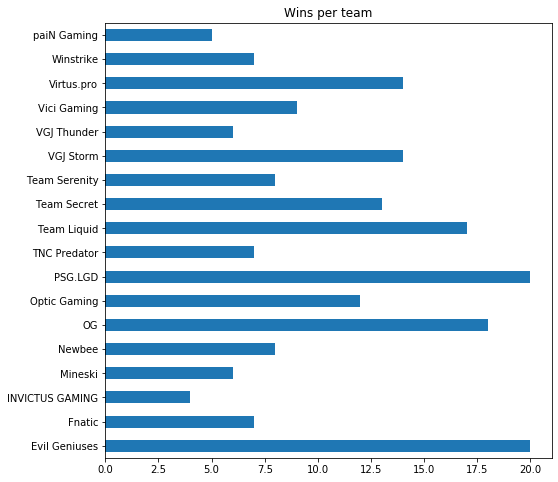

In [8]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("Wins per team")
wins_per_team.plot.barh()
plt.show()

#### 8. Plot a histogram of the total number of kills per match

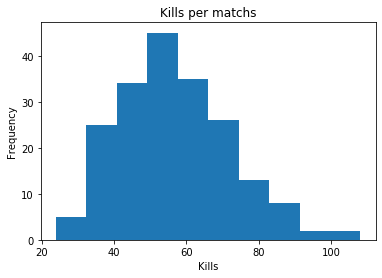

In [9]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.title("Kills per matchs")
plt.xlabel("Kills")
df.total_kills.plot.hist()
plt.show()

## Advanced questions

These questions require more code. Feel free to add code cells with your own functions and even some brief explanations on how you intend to solve them.

#### 9. What are the top 3 heroes played on the Radiant side? Top 3 on the Dire?

In [10]:
from collections import Counter
def count_heroes(heroes_team):
    li = []
    for heroes_list in heroes_team:
        for heroe in heroes_list:
           li.append(heroe)
    return Counter(li)

In [11]:
heroes_radiant = count_heroes(df.radiant_picks.values)
heroes_dire = count_heroes(df.dire_picks.values)

In [12]:
top_3_radiant = heroes_radiant.most_common(3)
top_3_dire = heroes_dire.most_common(3)

#### 10. What is the winrate (number of matches won / total matches) for the Radiant/Dire when they draft _Weaver_

Notice that the denominator is **not** the total number of matches in the dataset, but the number of matches where Weaver was picked for the Radiant/Dire.

In [13]:
# Cantidad de partidas donde "Radiant Team" eligió a Weaver:
radiant_weaver = len([listheroes for listheroes in df.radiant_picks if "Weaver" in listheroes])

# Cantidad de partidas donde Radiant Team ganó y eligió a Weaver:
radiant_weaver_win = len([listheroes for listheroes in df[df.radiant_win == True].radiant_picks if "Weaver" in listheroes])

# Cantidad de partidas donde Dire Team eligió a Weaver:
dire_weaver = len([listheroes for listheroes in df.dire_picks if "Weaver" in listheroes])
# Cantidad de partidas donde Dire Team ganó y eligió a Weaver:
dire_weaver_win = len([listheroes for listheroes in df[df.radiant_win == False].dire_picks if "Weaver" in listheroes])


In [14]:
radiant_weaver_winrate = radiant_weaver_win / radiant_weaver
dire_weaver_winrate = dire_weaver_win / dire_weaver